In [6]:
"""
DQN implementations.
Adapted from code at https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn
"""
# imports
import re
import time
import pickle
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from unityagents import UnityEnvironment

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# path information
PATH = "/Volumes/BC_Clutch/Dropbox/DeepRLND/rl_navigation/"
APP_PATH = PATH + "data/Banana.app"
CHART_PATH = PATH + "charts/"
CHECKPOINT_PATH = PATH + "models/"

score_target = 13.0 # 13.0 to meet project goals

state_size = 37
action_size = 4
seed = 0
n_episodes=1000
max_t=1000
eps_start=0.4
eps_end=0.01
eps_decay=0.995
train_mode=True

timestamp = re.sub(r"\D","",str(datetime.datetime.now()))[:12]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.97            # discount factor
ALPHA = 0.4
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network
SEED = 0

In [3]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, batch_size, seed, buffer_size=BUFFER_SIZE):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, alpha, beta):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
class PriorityReplayBuffer(ReplayBuffer):
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, batch_size, seed, buffer_size=BUFFER_SIZE):
        super().__init__(action_size, batch_size, seed, buffer_size=BUFFER_SIZE)
        """
        Prioritizes Experience Replay buffer to store experience tuples.
        """
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done","priority"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        max_priority = max([m.priority for m in self.memory]) if self.memory else 1.0
        e = self.experience(state, action, reward, next_state, done, max_priority)
        self.memory.append(e)

    def sample(self, alpha, beta):
        """Randomly sample a batch of experiences from memory."""
        priorities = np.array([sample.priority for sample in self.memory])
        probs = priorities ** alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.memory), self.batch_size, replace=False, p=probs)
        
#         experiences = random.sample(self.memory, k=self.batch_size)
        experiences = [self.memory[idx] for idx in indices]
    
        total = len(self.memory)
        weights = (total*probs[indices])**(-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        weights = torch.from_numpy(np.vstack(weights)).float().to(device)
        indices = torch.from_numpy(np.vstack(indices)).long().to(device)
        return (states, actions, rewards, next_states, dones, weights, indices)

    def update_priorities(self, indices, priorities):
        for i, idx in enumerate(indices):
            self.memory[idx] = self.memory[idx]._replace(priority=priorities[i])
    
class Vanilla:
    """
    Interacts with and learns from the environment.
    Inspired by code from https://github.com/franckalbinet/drlnd-project1/blob/master/dqn_agent.py
    """

    def __init__(self, state_size, action_size, seed,buffer_size=BUFFER_SIZE, 
                 batch_size=BATCH_SIZE, gamma=GAMMA, lr=LR,update_every=UPDATE_EVERY):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.buffer_size = int(buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory 
        self.memory = ReplayBuffer(action_size, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done, beta=1.0):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample(ALPHA, beta)
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def train(model_name, agent, n_episodes, max_t, eps_start, eps_end, eps_decay,train_mode):
        """Deep Q-Learning.

        Params
        ======
            n_episodes (int): maximum number of training episodes
            max_t (int): maximum number of timesteps per episode
            eps_start (float): starting value of epsilon, for epsilon-greedy action selection
            eps_end (float): minimum value of epsilon
            eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        """
        env_info = env.reset(train_mode)[brain_name]
        scores = []                        # list containing scores from each episode
        scores_window = deque(maxlen=100)  # last 100 scores
        eps = eps_start
        print("Loading monkey.")
        print("Monkey training on bananas.")
        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            for t in range(max_t):
                state = env_info.vector_observations[0]  # get the current state
                action = agent.act(state,eps)
                env_info = env.step(action)[brain_name]        # send the action to the environment
                next_state = env_info.vector_observations[0]   # get the next state
                reward = env_info.rewards[0]                   # get the reward
                done = env_info.local_done[0]
                agent.step(state, action, reward, next_state, done)
                score += reward                                # update the score
                state = next_state                             # roll over the state to next time step
                if done:                                       # exit loop if episode finished
                    break
            scores_window.append(score)       # save most recent score
            scores.append(score)              # save most recent score
            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=score_target:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                checkpath = CHECKPOINT_PATH + f'checkpoint-{model_name}-{timestamp}.pth'
                torch.save(agent.qnetwork_local.state_dict(), checkpath)
                print(f"Checkpoint saved at {checkpath}")
                break
        return scores
    
class Double(Vanilla):
    """
    Interacts with and learns from the environment.
    Inspired by code from https://github.com/franckalbinet/drlnd-project1/blob/master/dqn_agent.py
    """

    def __init__(self, state_size, action_size, seed,buffer_size=BUFFER_SIZE, 
                 batch_size=BATCH_SIZE, gamma=GAMMA, lr=LR,update_every=UPDATE_EVERY):
        super().__init__(state_size, action_size, seed,buffer_size=BUFFER_SIZE, 
                 batch_size=BATCH_SIZE, gamma=GAMMA, lr=LR,update_every=UPDATE_EVERY)

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        local_max_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = torch.gather(self.qnetwork_target(next_states).detach(),1,local_max_actions)
#         Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

class PriorityReplay(Double):
    """
    Interacts with and learns from the environment.
    Inspired by code from https://github.com/franckalbinet/drlnd-project1/blob/master/dqn_agent.py
    """

    def __init__(self, state_size, action_size, seed,buffer_size=BUFFER_SIZE, 
                 batch_size=BATCH_SIZE, gamma=GAMMA, lr=LR,update_every=UPDATE_EVERY):
        super().__init__(state_size, action_size, seed,buffer_size=BUFFER_SIZE, 
                 batch_size=BATCH_SIZE, gamma=GAMMA, lr=LR,update_every=UPDATE_EVERY)

        self.memory = PriorityReplayBuffer(action_size, batch_size, seed)
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, weights, indices = experiences

        local_max_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = torch.gather(self.qnetwork_target(next_states).detach(),1,local_max_actions)
#         Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = (Q_expected - Q_targets).pow(2)*weights
        prios = loss + 1e-5
        loss = loss.mean()
#         loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update priorities based on td error
        self.memory.update_priorities(indices.squeeze().to("cpu").data.numpy(),prios.squeeze().to("cpu").data.numpy())

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        

In [4]:
# setup and examine environment
env = UnityEnvironment(file_name=APP_PATH)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space
state = env_info.vector_observations[0]
print('States look like:\n', state)
state_size = len(state)
print('States have length:', state_size)

# train agent
result_dict = {}
function_list = [
                 ("Vanilla",Vanilla(state_size, action_size, seed)),
                 ("Double", Double(state_size, action_size, seed)),
                 ("PriorityReplay",PriorityReplay(state_size, action_size, seed))
                ]

for function in function_list:
    start = time.time()
    name = function[0]
    agent = function[1]
    print(f"\n**{name}**")
    scores = Vanilla.train(name, agent, n_episodes, max_t, eps_start, eps_end, eps_decay,train_mode)
    end = time.time()
    result_dict[name] = {
                    "scores":scores,
                    "clocktime":round((end-start)/60,2),
                    "state_size":state_size,
                    "action_size":action_size,
                    "seed":seed,
                    "n_episodes":n_episodes,
                    "max_t":max_t,
                    "eps_start":eps_start,
                    "eps_end":eps_end,
                    "eps_decay":eps_decay,
                    "train_mode":train_mode
                    }

pklpath = CHART_PATH + f"ResultDict-{timestamp}.pkl"
with open(pklpath, 'wb') as handle:
    pickle.dump(result_dict, handle)
print(f"Scores pickled at {pklpath}")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37

**Vanilla**
Loading monkey.
Monkey training on bananas.
Episode 100	Average Score: 3.38
Episode 200	Average Score: 8.63
Episode 300	Average Score: 11.61
Episode 395	Average Score: 13.04
Environment solved in 395 episodes!	Average Score: 13.04
Checkpoint saved at /Volumes/BC_Clutch/Dropbox/DeepRLND/rl_navigation/models/checkpoint-Vanilla-201811242020.pth

**Double**
Loading monkey.
Monkey training on bananas.
Episode 100	Average Score: 1.68
Episode 200	Average Score: 6.06
Episode 300	Average Score: 7.32
Episode 400	Average Score: 11.83


### Plot results

/Users/brianmcmahon/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Chart saved at /Volumes/BC_Clutch/Dropbox/DeepRLND/rl_navigation/charts/NavigationTrainChart-201811242020.png


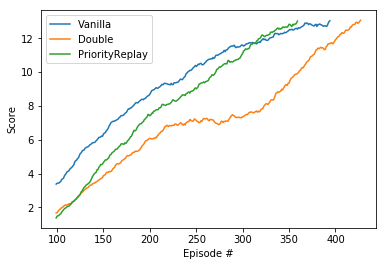

In [7]:
roll_length = 100 # averaging window
results = pd.DataFrame(result_dict)
chartpath = CHART_PATH + f"NavigationTrainChart-{timestamp}.png"

fig = plt.figure()
ax = fig.add_subplot(111)
for mod in results.columns:
    scores = results[mod]['scores']
    avg_scores = []
    for i in range(1,len(scores)+1):
        start = np.max(i-roll_length,0)
        end = i
        nm = np.sum(scores[start:end])
        dn = len(scores[start:end])
        avg_scores.append(nm/dn)
    plt.plot(np.arange(len(scores)), avg_scores,label=mod)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend()
plt.savefig(chartpath)
print(f"Chart saved at {chartpath}")
plt.show()
# display(results)